# Implement

In [2]:
from project import Projection
from Problem import Problem
from main import run_experiment
from utils import visualize_pareto_front

In [3]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import pandas as pd

# Define

In [4]:
def f(x):
    return np.array([
        4*x[0]**2 + 4*x[1]**2,
        (x[0] - 5)**2 + (x[1] - 5)**2
    ])


#--------------- C --------------------#
def c1(x):
    return -(x[0] - 5)**2 - x[1]**2 + 25
def c2(x):
    return -(x[0] - 8)**2 - (x[1] + 3)**2 + 17.7


#--------------- Q --------------------#
def q1(y):
    return 50**2 - (y[0] - 50)**2 - (y[1] - 50)**2

def q_plus(y):
    center = 50.0
    radius_sq = 50**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

# Hàm dùng cho Projection 
cons_C = (
    {
        'type': 'ineq', 'fun' : c1,     
    },
    {
        'type': 'ineq', 'fun' : c2,     
    }
)

dim_x = 2
bounds_x = Bounds([-15,-15],[30, 30])

cons_Q = (
    {
        'type': 'ineq', 'fun' : q1,     
    },    
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus},
)
dim_y = 2

In [5]:
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian(f)], C=[], Q=[], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

In [ ]:
results = run_experiment(prob)

=== BẮT ĐẦU PHASE 1: TÌM ĐIỂM KHẢ THI ===


  2%|▏         | 1/50 [00:00<00:00, 111.12it/s]


Hội tụ tại vòng lặp 1
-> Điểm khả thi (Feasible Point): [ 3.8345583 -2.4091569]

=== BẮT ĐẦU PHASE 2: SCALARIZATION (MULTI-RAY) ===
Running Ray 1/25: [0.99678533 0.08011867]


Running Ray 2/25: [0.9903591  0.13852387]
Running Ray 3/25: [0.98051368 0.19645082]
Running Ray 4/25: [0.96728307 0.25369953]
Running Ray 5/25: [0.95071296 0.31007236]
Running Ray 6/25: [0.93086054 0.36537467]
Running Ray 7/25: [0.90779436 0.41941554]
Running Ray 8/25: [0.88159406 0.47200839]


In [ ]:
pf_true_targets = np.load('tmp/pf_true.npy')
pf_ref_cloud = np.load('tmp/pf.npy')

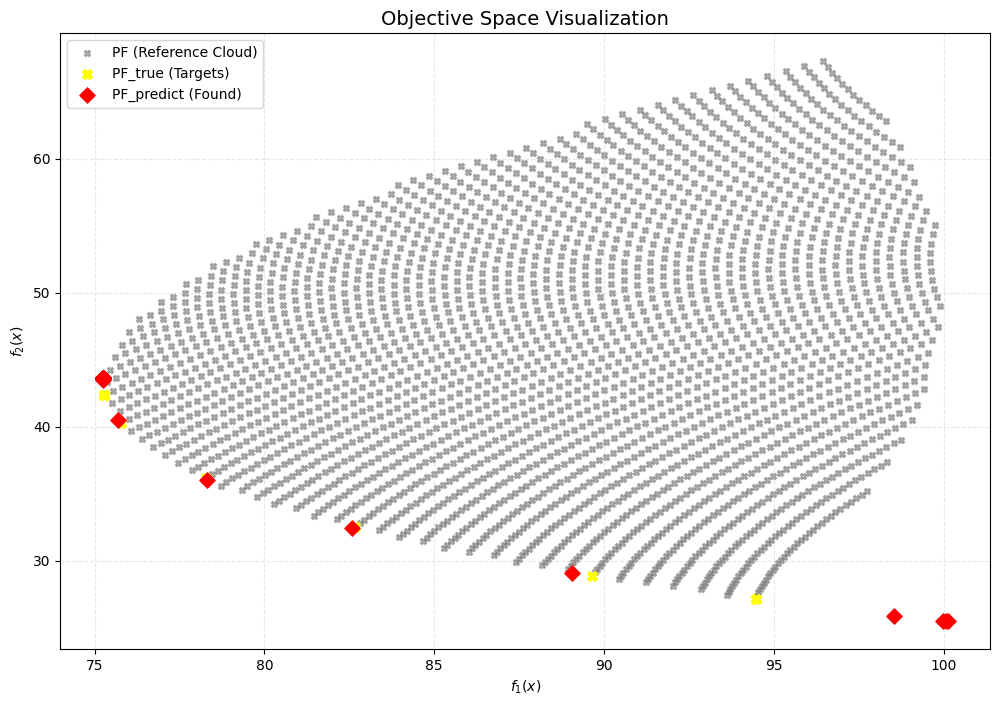

In [7]:
visualize_pareto_front(
    results=results, 
    pf_cloud=pf_ref_cloud,   
    pf_targets=pf_true_targets,
    title="Objective Space Visualization",
    figsize=(12, 8)
)

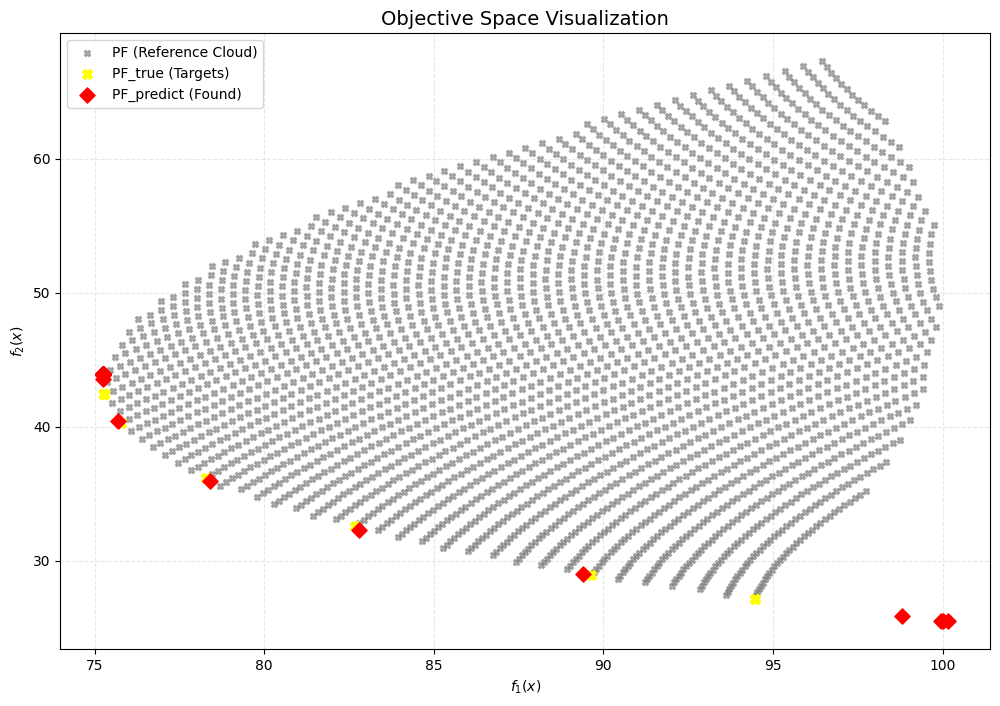

In [7]:
visualize_pareto_front(
    results=results, 
    pf_cloud=pf_ref_cloud,   
    pf_targets=pf_true_targets,
    title="Objective Space Visualization",
    figsize=(12, 8)
)

In [8]:
def visualize_pareto_with_trajectories(results, prob, pf_cloud=None, pf_targets=None, title="Trajectory in Objective Space", save_path=None, figsize=(10, 8)):
    """
    Vẽ không gian mục tiêu kèm theo quỹ đạo di chuyển của thuật toán.
    
    Args:
        results (dict): Dictionary kết quả từ run_experiment.
        prob (object): Đối tượng bài toán (cần để tính f(x) từ x).
        pf_cloud (np.array): Tập Pareto tham chiếu (màu xám).
        pf_targets (np.array): Tập Pareto đích thực sự (màu vàng).
    """
    
    # 1. Lấy dữ liệu
    pareto_f = results.get('pareto_f')
    paths_x = results.get('all_paths', [])
    x_feasible_start = results.get('x_feasible_phase1')
    
    # Tạo plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # ---------------------------------------------------------
    # LỚP 1: NỀN (Background) - Giống hệt hàm cũ
    # ---------------------------------------------------------
    # Vẽ đám mây điểm Pareto tham chiếu (Màu xám)
    if pf_cloud is not None:
        ax.scatter(
            pf_cloud[:, 0], pf_cloud[:, 1], 
            s=20, c="gray", marker="X", alpha=0.5, 
            label="PF (Reference)"
        )

    # Vẽ các điểm đích thực sự (Màu vàng)
    if pf_targets is not None:
        ax.scatter(
            pf_targets[:, 0], pf_targets[:, 1], 
            s=50, c="yellow", marker="X", 
            label="PF_true (Targets)", zorder=5
        )

    # ---------------------------------------------------------
    # LỚP 2: QUỸ ĐẠO (Trajectories) - Phần mới thêm vào
    # ---------------------------------------------------------
    if paths_x and prob is not None:
        print("Đang tính toán ánh xạ quỹ đạo từ X-space sang F-space...")
        
        # Duyệt qua từng đường dẫn (tương ứng với từng tia/ray)
        for i, path_x in enumerate(paths_x):
            path_x = np.array(path_x)
            path_f = []
            
            # Ánh xạ từng điểm x trong lịch sử thành f(x)
            for x_val in path_x:
                f_val = prob.objective_func(x_val) # Tính f1, f2
                path_f.append(f_val)
            
            path_f = np.array(path_f)
            
            # Vẽ đường dây (Line plot)
            # Dùng màu xanh dương nhạt (blue) hoặc tím để phân biệt
            ax.plot(
                path_f[:, 0], path_f[:, 1], 
                c='blue', alpha=0.3, linewidth=1, 
                linestyle='-', zorder=3
            )

    # Vẽ điểm xuất phát (Start Point - Kết quả của Phase 1)
    if x_feasible_start is not None and prob is not None:
        f_start = prob.objective_func(x_feasible_start)
        ax.scatter(
            f_start[0], f_start[1], 
            s=80, c="lime", marker="*", edgecolors='black',
            label="Phase 1 Result (Start)", zorder=6
        )

    # ---------------------------------------------------------
    # LỚP 3: ĐIỂM CUỐI (Final Points) - Giống hệt hàm cũ
    # ---------------------------------------------------------
    if pareto_f is not None and len(pareto_f) > 0:
        ax.scatter(
            pareto_f[:, 0], pareto_f[:, 1], 
            s=60, c="red", marker="D", 
            label="PF_predict (Final)", zorder=10
        )

    # ---------------------------------------------------------
    # TRANG TRÍ
    # ---------------------------------------------------------
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("$f_1(x)$")
    ax.set_ylabel("$f_2(x)$")
    
    # Chỉ hiển thị legend 1 lần cho các thành phần trùng lặp
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')
    
    ax.grid(True, linestyle='--', alpha=0.3)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Đã lưu hình ảnh tại: {save_path}")
        
    plt.show()